In [3]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
import numpy as np
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

In [11]:
os.getcwd()

'/network/scratch/w/weissmar/tn/info-bazaar/notebooks'

In [4]:
with open("../data/machine-learning/dataset_step_1.json", "r") as f:
    x = f.read()

In [5]:
dataset = json.loads(x)

In [61]:
# dataset["2105.11207"]["blocks"][0]

In [42]:

# Initialize empty lists
all_embeddings = []
all_arxiv_ids = []
all_nugget_answers = []
all_nugget_questions = []

# Iterate over dataset to collect all embeddings and corresponding arxiv_id
for arxiv_id, data in dataset.items():
    for block in data['blocks']:
        for nugget in block.get("nuggets", []):
            all_embeddings.append(np.array(nugget['embedding']))
            all_arxiv_ids.append(arxiv_id) 
            all_nugget_answers.append(nugget['answer'])
            all_nugget_questions.append(nugget['question'])
            break

# Convert lists to numpy arrays
all_embeddings = np.array(all_embeddings)
all_arxiv_ids = np.array(all_arxiv_ids)
all_nugget_answers = np.array(all_nugget_answers)
all_nugget_questions = np.array(all_nugget_questions)
# Compute t-SNE
tsne = TSNE(n_components=2, random_state=0,init="pca")
tsne_embeddings = tsne.fit_transform(all_embeddings)

# Create a DataFrame to hold t-SNE, arxiv_id and nugget_answers
df = pd.DataFrame({
    'x': tsne_embeddings[:, 0],
    'y': tsne_embeddings[:, 1],
    'arxiv_id': all_arxiv_ids,
    'nugget_question': all_nugget_questions,
    'nugget_answer': all_nugget_answers
})

# Plot with plotly
fig = px.scatter(df, x='x', y='y', color='arxiv_id', hover_data=['nugget_answer', 'nugget_question'])
fig.show()


/home/mila/w/weissmar/.conda/envs/tn/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/home/mila/w/weissmar/.conda/envs/tn/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



/home/mila/w/weissmar/.conda/envs/tn/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/mila/w/weissmar/.conda/envs/tn/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [62]:
# for arxiv_id, blob in dataset.items():
#     print(arxiv_id)
#     print(blob.get("embedding_df"))
#     nugget_questions = blob['embedding_df']['nugget_questions']
#     nugget_answers = blob['embedding_df']['nugget_answers']
#     embeddings = np.array(blob['embedding_df']['embeddings'])
    
#     break

In [17]:
# [len(x.get("nuggets", [])) for x in dataset["2105.04798"]["blocks"]]

In [18]:
# [b["block_id"] for b in dataset["2105.04798"]["blocks"]]

In [20]:
intro_embeddings = []
intro_metadata = []
nugget_embeddings = []
nugget_metadata = []

for arxiv_id, blob in dataset.items(): 
    for block in blob["blocks"]: 
        try: 
            _arx_id, *sections, block_idx = block["block_id"].split("/")
        except Exception: 
            print(block["block_id"])
            raise
        assert _arx_id == arxiv_id
        if sections[0].lower() != "introduction":
            continue
        intro_embeddings.append(block["embedding"])
        block_metadata = dict(arxiv_id=arxiv_id, sections=sections, block_id=int(block_idx), content=block["content"])
        intro_metadata.append(block_metadata)
        for nugget_idx, nugget in enumerate(block.get("nuggets", [])): 
            nugget_embeddings.append(nugget["embedding"])
            nugget_metadata.append(dict(**block_metadata, nugget_idx=nugget_idx, question=nugget["question"], answer=nugget["answer"]))

intro_embeddings = np.array(intro_embeddings)
nugget_embeddings = np.array(nugget_embeddings)

In [21]:
blob["blocks"][0]["nuggets"][0].keys()

dict_keys(['question', 'answer', 'embedding'])

In [22]:
intro_embeddings.shape

(616, 1536)

In [23]:
nugget_embeddings.shape

(417, 1536)

In [24]:
nugget_intro_match = cosine_similarity(nugget_embeddings, intro_embeddings)

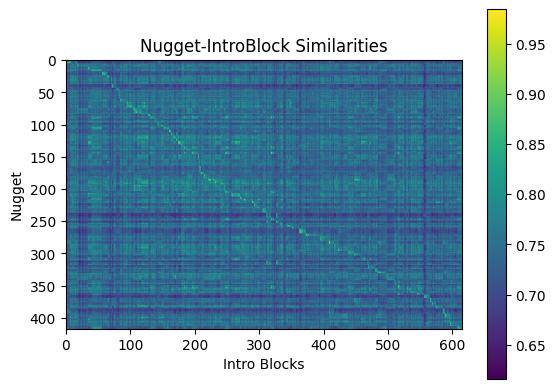

In [25]:
plt.figure()
plt.imshow(nugget_intro_match)
plt.xlabel("Intro Blocks")
plt.ylabel("Nugget")
plt.colorbar()
plt.title("Nugget-IntroBlock Similarities")
plt.show()

In [26]:
top_similar_intros_for_nugget = np.argsort(nugget_intro_match, axis=-1)[:, ::-1]

In [35]:
# nugget_metadata[0]

In [40]:
# top_similar_intros_for_nugget[0]

In [130]:
# top_similar_intros_for_nugget[1].tolist()

In [37]:
top_not_self_intro_block_idx_for_nugget = []
top_not_self_intro_block_rnk_for_nugget = []

for nugidx in range(nugget_embeddings.shape[0]): 
    similar_intro_idxs = top_similar_intros_for_nugget[nugidx].tolist()
    for enum_idx, inidx in enumerate(similar_intro_idxs):
        if intro_metadata[inidx]["arxiv_id"] != nugget_metadata[nugidx]["arxiv_id"]: 
            top_not_self_intro_block_idx_for_nugget.append(inidx)
            top_not_self_intro_block_rnk_for_nugget.append(enum_idx + 1)
            break
top_not_self_intro_block_idx_for_nugget = np.array(top_not_self_intro_block_idx_for_nugget)
top_not_self_intro_block_rnk_for_nugget = np.array(top_not_self_intro_block_rnk_for_nugget)

10

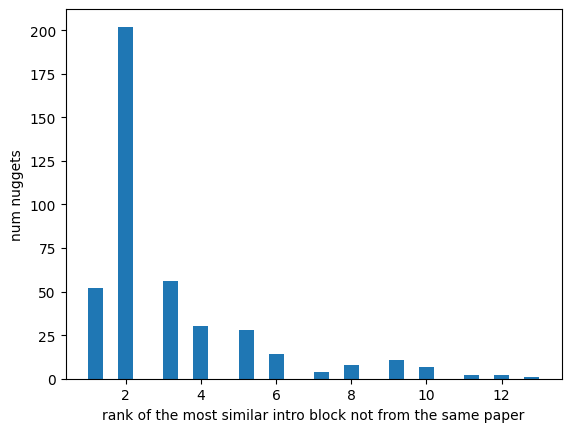

In [145]:
plt.figure()
plt.hist(top_not_self_intro_block_rnk_for_nugget, bins=30)
plt.xlabel("rank of the most similar intro block not from the same paper")
plt.ylabel("num nuggets")
plt.show()

In [150]:
# This is the idx of the nugget in question
top_not_self_intro_block_rnk_for_nugget.argsort()

array([158,  35, 403, 345, 344, 125, 338,  47, 336, 335, 334,  51, 333,
       332, 207,  56, 317,  59, 316, 312, 311, 112, 305, 298, 291, 290,
       289, 285, 247, 248,  34,  33, 206, 352, 402, 401, 399, 161, 162,
       163,   9, 183, 380, 145,  17, 144, 142, 141,  95, 140])

In [151]:
# This is the idx of the block in question
top_not_self_intro_block_idx_for_nugget[top_not_self_intro_block_rnk_for_nugget.argsort()]

array([ 64, 126, 336, 297, 516,  35, 170, 240, 135, 170, 170, 425, 170,
        24, 180, 523,  70, 514, 312, 311, 311, 171, 514, 297, 118, 117,
       117, 510, 249, 252, 126, 117,  34, 318,  34,  35, 118, 517,   9,
       528, 189, 105, 117, 318,   2, 318, 318, 539, 117, 507])

In [41]:
for pridx, (nugidx, inidx) in enumerate(zip(top_not_self_intro_block_rnk_for_nugget.argsort(), top_not_self_intro_block_idx_for_nugget[top_not_self_intro_block_rnk_for_nugget.argsort()])):
    print(f"Nugget {nugidx} - Block {inidx}")
    print()
    print("Question      :\n   ", nugget_metadata[nugidx]["question"])
    print()
    print("True Answer   :\n   ", nugget_metadata[nugidx]["answer"])
    print()
    print("Correct Block :\n   ", nugget_metadata[nugidx]["content"])
    print()
    print("Found Block   :\n   ", intro_metadata[inidx]["content"])
    print()
    print("Question from :\n   ", nugget_metadata[nugidx]["arxiv_id"])
    print()
    print("Answer in     :\n   ", intro_metadata[inidx]["arxiv_id"])
    print()
    print("Similarity    :\n   ", nugget_intro_match[nugidx, inidx])
    print()
    print("NotSelf Rank  :\n   ", top_not_self_intro_block_rnk_for_nugget[nugidx])
    print()
    print("------------------------")
    print("------------------------")
    print()
    if pridx > 50: 
        break

Nugget 158 - Block 64

Question      :
    What are some methods that enhance the computational efficiency of Monte Carlo simulation?

True Answer   :
    Researchers have developed methods such as importance sampling, subset simulations, and directional simulations to enhance the computational efficiency of Monte Carlo simulation. These methods have superior convergence rates compared to crude Monte Carlo simulation, but still require a considerable number of simulations to achieve accurate estimations.

Correct Block :
    It is well known that uncertainties inherently exist in practical engineering systems in various forms, such as randomness associated with the geometrical configurations, material properties, boundary conditions and loading conditions. Therefore, quantitative assessment of reliability becomes extremely important in practice [ditlevsen1996structural]. Though the evaluation of failure probability can be analytically formulated as a multi variate integral [haldar2000r

In [157]:
intro_metadata[126]

{'arxiv_id': '2105.04026',
 'sections': ['Introduction'],
 'block_id': 9,
 'content': 'Given the fact that the two main ingredients of deep neural networks have been around for a long time, one would expect that a comprehensive mathematical theory has been developed that describes why and when deep-learning-based methods will perform well or when they will fail.  Statistical learning theory\xa0[anthony1999neural, vapnik1999overview, cucker2002mathematical, bousquet2003introduction, vapnik2013nature] describes multiple aspects of the performance of general learning methods and in particular deep learning. We will review this theory in the context of deep learning in Subsection\xa0<ref> below. Hereby, we focus on classical, deep learning-related results that we consider well-known in the machine learning community. Nonetheless, the choice of these results is guaranteed to be subjective. We will find that the presented, classical theory is too general to explain the performance of deep le